In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import scipy.interpolate
import scipy.constants as C
import ase.data
import os
%matplotlib inline  

In [3]:
ad = pd.DataFrame(data={"symbol": ase.data.chemical_symbols,
                                "name"  : ase.data.atomic_names,
                                "mass"  : ase.data.atomic_masses } ) # atomic data

In [4]:
str_DSm = {'C': 12, 'H': 25, 'S': 1, 'O': 4}
M_DSm = 0
for sym, n in str_DSm.items():
    M_DSm += ad[ ad.symbol == sym ]['mass'].values[0] * n * C.gram

In [5]:
M_DSm

0.265388

In [6]:
str_CTAp = {'C': 19, 'H': 42, 'N': 1}
M_CTAp = 0
for sym, n in str_CTAp.items():
    M_CTAp += ad[ ad.symbol == sym ]['mass'].values[0] * n * C.gram

In [7]:
# set accordingly:
prefix = '/mnt/dat/work/testuser/git/N_surfactant_on_substrate_template'

In [8]:
qcm_results_raw = pd.read_csv(
    os.path.join(prefix,'bramos/qcm_results.csv'),
            delimiter=',',comment='#',header=None,names=["c","GammaM"])
# cE      : bulk concenctration / mM 
# GammaM : surface mass density / ng cm^-2
ctab_results_raw = pd.read_csv(
    os.path.join(prefix,'bramos/kawasaki2007influence_fig1b.csv'),
            delimiter=',',comment='#',header=None,names=["c","GammaM"])
# cE      : bulk concenctration / mM 
# GammaM : surface mass density / ng cm^-2

In [9]:
qcm_results = pd.concat([    
    qcm_results_raw[["c"]]*C.milli, # mM --> M
    qcm_results_raw[["GammaM"]] * (C.nano * C.gram) / C.centi**2 # ng cm^-2 --> kg m^-2
    ], axis=1)
ctab_results = pd.concat([    
   ctab_results_raw[["c"]]*C.milli, # mM --> M
   ctab_results_raw[["GammaM"]] * (C.nano * C.gram) / C.centi**2 # ng cm^-2 --> kg m^-2
    ], axis=1)

In [10]:
# surface concentration, kg m^-2 * (mol/kg) = mol m^-2
qcm_results[["GammaC"]] = qcm_results[["GammaM"]] / M_DSm
ctab_results[["GammaC"]] = ctab_results[["GammaM"]] / M_CTAp

In [11]:
# surface number density, mol m^-2 * (mol^-1) = m^-2
qcm_results[["GammaN"]] = qcm_results[["GammaC"]] * C.Avogadro
ctab_results[["GammaN"]] =ctab_results[["GammaC"]] * C.Avogadro

In [12]:
# area per molecule, m^2
qcm_results[["A"]] = 1 / qcm_results[["GammaN"]]
ctab_results[["A"]] = 1 /ctab_results[["GammaN"]]

In [13]:
pkl_file = os.path.join(prefix,"dat","sys","SDS_on_AU_111.pkl")
sds_df = pd.read_pickle(pkl_file)
pkl_file2 = os.path.join(prefix,"dat","sys","CTAB_on_AU_111.pkl")
sds_df2 = pd.read_pickle(pkl_file2)

In [14]:
## Not used, all sb_multiples give the same sf
lst=[]
lst2=[]
for i in range(sds_df.shape[0]):
    if (np.array((sds_df["sb_multiples"].values[i].tolist()))==np.array([51, 30, 2])).all():
        lst.append(i)
for i in range(sds_df2.shape[0]):
    if (np.array((sds_df2["sb_multiples"].values[i].tolist()))==np.array([51, 30, 2])).all():
        lst2.append(i)

In [15]:
a=((1/sds_df.loc[:]["sb_area_per_sf_molecule"])*1e-18).sort_values()
a2=((1/sds_df2.loc[:]["sb_area_per_sf_molecule"])*1e-18).sort_values()

In [16]:
b=sds_df.loc[:]["sf_concentration"].sort_values()
b2=sds_df2.loc[:]["sf_concentration"].sort_values()

In [17]:
exp =scipy.interpolate.interp1d(np.array(qcm_results[["c"]] / C.milli).reshape(len(np.array(qcm_results[["c"]] ))), 
                                 np.array(qcm_results[["GammaN"]] * C.nano**2).reshape(len(qcm_results[["GammaN"]])),
                                 axis=0, kind='linear', bounds_error=False,
                                 fill_value="extrapolate")
exp2 =scipy.interpolate.interp1d(np.array(ctab_results[["c"]] / C.milli).reshape(len(np.array(ctab_results[["c"]] ))), 
                                 np.array(ctab_results[["GammaN"]] * C.nano**2).reshape(len(ctab_results[["GammaN"]])),
                                 axis=0, kind='linear', bounds_error=False,
                                 fill_value="extrapolate")
exp3 =scipy.interpolate.interp1d( np.array(qcm_results[["GammaN"]] * C.nano**2).reshape(len(qcm_results[["GammaN"]])),
                                np.array(qcm_results[["c"]] / C.milli).reshape(len(np.array(qcm_results[["c"]] ))),
                                 axis=0, kind='linear', bounds_error=False,
                                 fill_value="extrapolate")

In [18]:
bm=b.drop_duplicates()/ C.milli
interpolated_sf = pd.DataFrame(exp(bm)).drop_duplicates()
bm2=b2.drop_duplicates()/ C.milli
interpolated_sf_2 = pd.DataFrame(exp2(bm2)).drop_duplicates()

In [19]:
suggested_points=np.array([0.1,0.15,0.55,1,1.5,2.8,12])
suggested_sf =exp(suggested_points)
suggested_sf

array([0.04656477, 0.15263953, 0.83211879, 1.34992712, 2.40946526,
       3.28084574, 3.56892429])

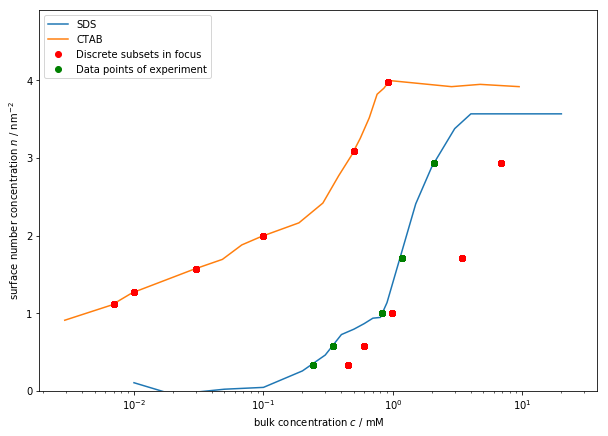

In [22]:
plt.figure(figsize=(10,7))
plt.plot( qcm_results[["c"]] / C.milli ,qcm_results[["GammaN"]] * C.nano**2)
plt.plot(ctab_results[["c"]] / C.milli ,ctab_results[["GammaN"]] * C.nano**2)
plt.plot( b / C.milli ,a, 'ro')
plt.plot(exp3(a),a,'go')
#plt.plot(bm[0:len(interpolated_sf)],interpolated_sf,'go')
plt.plot( b2 / C.milli ,a2, 'ro')
#plt.plot(bm2[0:len(interpolated_sf_2)],interpolated_sf_2,'go')
plt.xscale("log")
plt.legend(["SDS","CTAB","Discrete subsets in focus",'Data points of experiment'])
plt.xlabel(r'bulk concentration $ c \ / \ \mathrm{mM}$')
plt.ylabel(r'surface number concentration $ n \ / \ {\mathrm{nm}^{-2}}$')
plt.ylim((0,4.9))
plt.show()

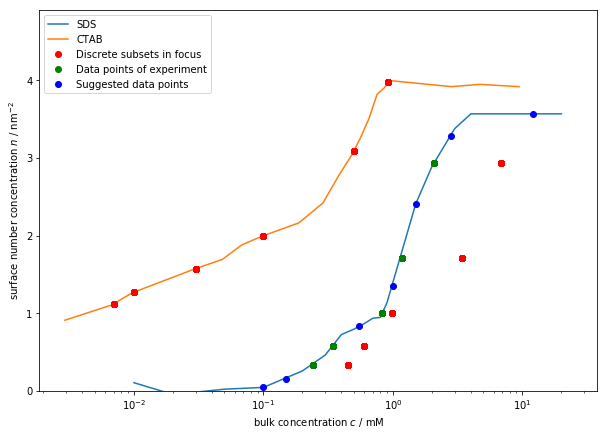

In [131]:
plt.figure(figsize=(10,7))
plt.plot( qcm_results[["c"]] / C.milli ,qcm_results[["GammaN"]] * C.nano**2)
plt.plot(ctab_results[["c"]] / C.milli ,ctab_results[["GammaN"]] * C.nano**2)
plt.plot( b / C.milli ,a, 'ro')
plt.plot(exp3(a),a,'go')
#plt.plot(bm[0:len(interpolated_sf)],interpolated_sf,'go')
plt.plot(suggested_points,suggested_sf,'bo')
plt.plot( b2 / C.milli ,a2, 'ro')
#plt.plot(bm2[0:len(interpolated_sf_2)],interpolated_sf_2,'go')
plt.xscale("log")
plt.legend(["SDS","CTAB","Discrete subsets in focus",'Data points of experiment','Suggested data points'])
plt.xlabel(r'bulk concentration $ c \ / \ \mathrm{mM}$')
plt.ylabel(r'surface number concentration $ n \ / \ {\mathrm{nm}^{-2}}$')
plt.ylim((0,4.9))
plt.show()

In [140]:
number_of_molecules=suggested_points*229.5 
#229.5 nm^2
number_of_molecules

array([  22.95 ,   34.425,  126.225,  229.5  ,  344.25 ,  642.6  ,
       2754.   ])